In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import torch
from sklearn.externals import joblib

# local modules
import fileio
import features
import keys
import evaluation
from utils import grouped_bar_chart, number_countplot

FS = fileio.FS
NUM_SAMPLES = fileio.NUM_SAMPLES
OUTPUT_PREFIX = fileio.OUTPUT_PREFIX  # location of fitted models

In [4]:
# plt.rcParams['figure.figsize'] = [6.0, 4.0]  # Default
mult = 2/3
plt.rcParams['figure.figsize'] = [6.0*mult, 4.0*mult]
WIDEFIG_SIZE = (10.0*mult, 4.0*mult)

# Load data

In [5]:
DATA_DIR = './data/working'

# Full dataset
X = np.load("{}/X_cqt.npz".format(DATA_DIR))['X']
Y = np.load("{}/Y.npz".format(DATA_DIR))['Y']
labels = pd.read_pickle("{}/labels.pkl".format(DATA_DIR))

# Indeces for splits
with np.load("{}/splits.npz".format(DATA_DIR)) as splits:
    train_idx = splits['train_idx']
    test_idx = splits['test_idx']

# Splits prior to augmentation
X_train = X[train_idx, :]
Y_train = Y[train_idx, :]
labels_train = labels.iloc[train_idx]
X_test = X[test_idx, :]
Y_test = Y[test_idx, :]
labels_test = labels.iloc[test_idx]

# The data with which we augment the training data
with np.load("{}/data_aug.npz".format(DATA_DIR)) as data:
    X_aug = data['X']
    Y_aug = data['Y']
labels_aug = pd.DataFrame(np.argmax(Y_aug, axis=1), columns=['key'])
labels_aug['raw'] = 0.0
labels_aug['dataset'] = 'augmented'

# Augmented data used for training
X_train_aug = np.vstack([X_train, X_aug])
Y_train_aug = np.vstack([Y_train, Y_aug])
labels_train_aug = pd.concat([labels.iloc[train_idx], labels_aug], axis=0, sort=False)

Data description:
* All imported data (see `fileio` for how these were made):
    - `X` - cqt of each waveform
    - `Y` - one-hot representation of key for each waveform
    - `labels` - key and other labels for each waveform
* `train_idx`, `test_idx` - train and test indices for splits (created with `fileio.train_test_split`)
* Testing data:
    - `*_test`
* **Un-augmented** Training data:
    - `*_train`
* The data which augments the training data:
    - `*_aug`
* **Augmented** Training data:
    - `*_train_aug`
    
N.B. The test data is not augmented. The augmented training data has the same number of examples for each key.

# Get predicted probabilities

In [6]:
pred_probs = {}

## GPU config

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## OM1

### Data preprocessing

In [8]:
X_train_torch = torch.from_numpy(X_train_aug).float()
X_test_torch = torch.from_numpy(X_test).float()

### Load model

In [9]:
model_pkl_loc = '{}/MO1_model_best.pkl'.format(OUTPUT_PREFIX)
mdl = torch.load(model_pkl_loc).to(device)

### Make predictions

In [10]:
batch_size = 1024
X_torch = X_train_torch
nr_obs = X_torch.shape[0]
num_batches = int(np.ceil(nr_obs / batch_size))
pred_prob_train = []
for batch_num in range(num_batches):
    from_idx = batch_size * batch_num
    to_idx = min(batch_size * (batch_num+1), nr_obs)
    X_batch = X_torch[from_idx:to_idx]
    X_batch = X_batch.to(device)
    pred = mdl(X_batch).to('cpu')
    pred_prob_train += [pred.detach().numpy()]

In [11]:
pred_prob_train = np.vstack(pred_prob_train)

In [12]:
batch_size = 1024
X_torch = X_test_torch
nr_obs = X_torch.shape[0]
num_batches = int(np.ceil(nr_obs / batch_size))
pred_prob_test = []
for batch_num in range(num_batches):
    from_idx = batch_size * batch_num
    to_idx = min(batch_size * (batch_num+1), nr_obs)
    X_batch = X_torch[from_idx:to_idx]
    X_batch = X_batch.to(device)
    pred = mdl(X_batch).to('cpu')
    pred_prob_test += [pred.detach().numpy()]

In [13]:
pred_prob_test = np.vstack(pred_prob_test)

In [14]:
pred_probs['OM1'] = {'train': pred_prob_train, 'test': pred_prob_test}

## OM2

### Load model

In [15]:
model_pkl_loc = '{}/MO2_model_best.pkl'.format(OUTPUT_PREFIX)
mdl = torch.load(model_pkl_loc).to(device)

### Make predictions

In [16]:
batch_size = 1024
X_torch = X_train_torch
nr_obs = X_torch.shape[0]
num_batches = int(np.ceil(nr_obs / batch_size))
pred_prob_train = []
for batch_num in range(num_batches):
    from_idx = batch_size * batch_num
    to_idx = min(batch_size * (batch_num+1), nr_obs)
    X_batch = X_torch[from_idx:to_idx]
    X_batch = X_batch.to(device)
    pred = mdl(X_batch).to('cpu')
    pred_prob_train += [pred.detach().numpy()]

In [17]:
pred_prob_train = np.vstack(pred_prob_train)

In [18]:
batch_size = 1024
X_torch = X_test_torch
nr_obs = X_torch.shape[0]
num_batches = int(np.ceil(nr_obs / batch_size))
pred_prob_test = []
for batch_num in range(num_batches):
    from_idx = batch_size * batch_num
    to_idx = min(batch_size * (batch_num+1), nr_obs)
    X_batch = X_torch[from_idx:to_idx]
    X_batch = X_batch.to(device)
    pred = mdl(X_batch).to('cpu')
    pred_prob_test += [pred.detach().numpy()]

In [19]:
pred_prob_test = np.vstack(pred_prob_test)

In [20]:
pred_probs['OM2'] = {'train': pred_prob_train, 'test': pred_prob_test}

## OM3

### Data preprocessing

In [21]:
X_train_aug_mean = np.mean(X_train_aug, axis=2)
X_train_aug_mean -= np.mean(X_train_aug_mean, axis=1, keepdims=True)

X_test_mean = np.mean(X_test, axis=2)
X_test_mean -= np.mean(X_test_mean, axis=1, keepdims=True)

### Load model

In [22]:
model_pkl_loc = '{}/MO3_model_best.pkl'.format(OUTPUT_PREFIX)
mdl = joblib.load(model_pkl_loc)

### Make predictions

In [23]:
pred_prob_train = mdl.predict_proba(X_train_aug_mean)

In [24]:
pred_prob_test = mdl.predict_proba(X_test_mean)

In [25]:
pred_prob_train.shape, pred_prob_test.shape

((44424, 24), (4227, 24))

In [26]:
pred_probs['OM3'] = {'train': pred_prob_train, 'test': pred_prob_test}

# Plot results

In [27]:
def plot_results(pred_prob_train, pred_prob_test, Y_train, Y_test, labels_train, labels_test,
                 train_title='Train', test_title='Test'):
    y_train = np.argmax(Y_train, axis=1)
    y_test = np.argmax(Y_test, axis=1)
    pred_train = np.argmax(pred_prob_train, axis=1)
    pred_test = np.argmax(pred_prob_test, axis=1)
    
#     # Maybe adapt this to do train vs test pred prob quality comparison
#     plt.figure()
#     grouped_bar_chart(np.mean((Y_test - pred_prob_test)**2, axis=0, keepdims=True))
    
    plt.figure()
    evaluation.plot_confusion_matrix(y_train, pred_train, title=train_title, norm=True, annot=False)
    
    plt.figure()
    evaluation.plot_confusion_matrix(y_test, pred_test, title=test_title, norm=True, annot=False)
    
    scores_train = evaluation.get_scores(y_train, pred_train)
    plt.figure()
    plt.title('Train scores. Avg = {:.3f}'.format(np.mean(scores_train)))
    sns.countplot(scores_train)
    number_countplot()
    
    scores_test = evaluation.get_scores(y_test, pred_test)
    plt.figure()
    plt.title('Test scores. Avg = {:.3f}'.format(np.mean(scores_test)))
    sns.countplot(scores_test)
    number_countplot()

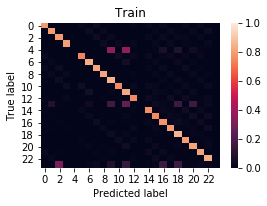

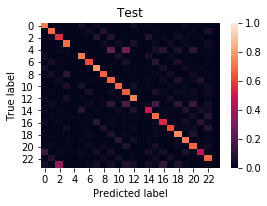

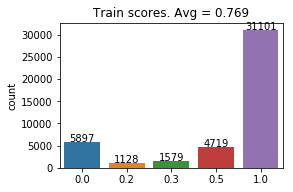

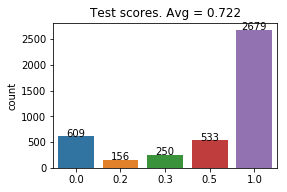

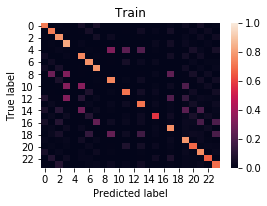

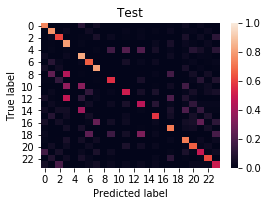

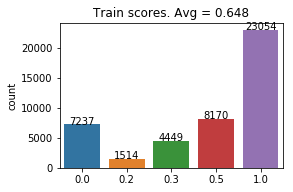

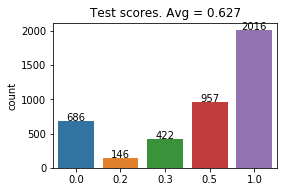

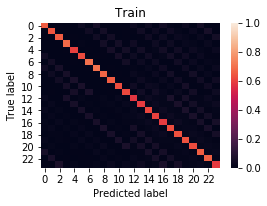

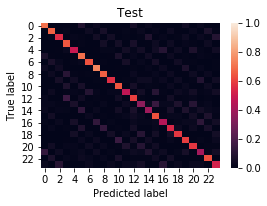

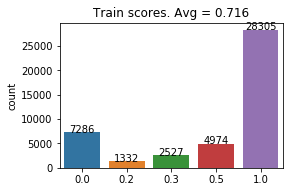

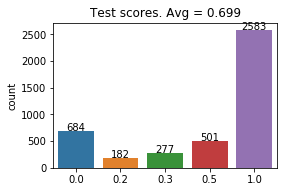

In [33]:
for model in ['OM{}'.format(ii) for ii in range(1, 4)]:
    plot_results(pred_probs[model]['train'], pred_probs[model]['test'],
                 Y_train_aug, Y_test, 
                 labels_train_aug, labels_test)